Import

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.spatial.distance import mahalanobis
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report
from torchvision.models import ResNet50_Weights
import torchvision.models as models
from PIL import Image
import torch
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

from sklearn.preprocessing import normalize

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from collections import Counter
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS

In [8]:
# Se CUDA disponibile, usa la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica ResNet50 pre-addestrata e in modalità eval
weights = ResNet50_Weights.IMAGENET1K_V1  # o DEFAULT per i pesi più aggiornati
model = models.resnet50(weights=weights)
model.eval()
model.to(device)

# Preprocessing standard per ResNet
preprocess = weights.transforms()


In [9]:
# Funzione per caricare l'immagine e fare la pre-elaborazione
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor

In [10]:
# Funzione per estrarre la media su ciascuna mappa di attivazione
def extract_and_process_image(img_path, model):
    img_tensor = preprocess_image(img_path)
    features = extract_resnet_features(img_tensor, model)
    features_vector = features.detach().mean(dim=[1, 2]).cpu().numpy()
    return features_vector

In [11]:
def load_features(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    return data['features'], data['labels'], data.get('filenames', [f"img_{i}" for i in range(len(data['features']))])


feat_matrix_part1, lbls_part1, flname_part1 = load_features(
    "resnet_features_part1.npz")
feat_matrix_part2, lbls_part2, flname_part2 = load_features(
    "resnet_features_part2.npz")

Task 1-2

In [12]:


# Funzione per estrarre le caratteristiche dal livello "layer3" della ResNet
def extract_resnet_features(img_tensor, model):
    def hook_fn(module, input, output):
        hook_fn.features = output

    hook = model.layer3[0].register_forward_hook(hook_fn)
    model(img_tensor)
    hook.remove()

    features = hook_fn.features.squeeze()
    return features



# Funzione per processare tutte le immagini in più sottocartelle



In [13]:
def process_and_save_features(base_folder, subfolders, output_file):
    """
    Estrae le feature FC da immagini in più cartelle e salva in un file .npz.
    """
    all_features = []
    all_filenames = []
    all_labels = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        if not os.path.isdir(folder_path):
            print(f"[ATTENZIONE] Cartella non trovata: {folder_path}")
            continue
        print(f"[INFO] Elaboro cartella: {label}")

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_and_process_image(img_path, model)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)
                else:
                    print(f"[ERRORE] Feature non estratte da {img_path}")

    # Salva in file .npz
    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")

In [14]:
# Parametri cartelle e output
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]


# Estrazione e salvataggio
process_and_save_features("Part1", subfolders, "resnet_features_part1")
process_and_save_features("Part2", subfolders, "resnet_features_part2")

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet_features_part1
[FINE] Totale immagini processate: 3006
[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet_features_part2
[FINE] Totale immagini processate: 3006


Task 3:

In [15]:

# --- Funzione con scelta metrica ---

def find_top_k_similar(query_img_path, k, features_npz_path, model, image_folder, metric):
    """
    Trova e visualizza le k immagini più simili rispetto all'immagine di query.

    Parametri:
    - query_img_path: percorso immagine di query
    - k: numero di immagini simili da mostrare
    - features_npz_path: file .npz con features, filenames, labels
    - model: modello ResNet già caricato
    - image_folder: cartella base delle immagini (per ricostruire i path)
    - metric: "euclidean" o "cosine" (default euclidean)
    """
    
    # Estrai feature per immagine query
    query_feature = extract_and_process_image(query_img_path, model).reshape(1, -1)

    if metric == "euclidean":
        # Distanza euclidea
        dists = np.linalg.norm(feat_matrix_part1 - query_feature, axis=1)
        # Più piccoli sono migliori (vicinanza)
        top_k_indices = np.argsort(dists)[:k]

    elif metric == "cosine":
        # Similarità coseno
        sim = cosine_similarity(query_feature, feat_matrix_part1)[0]  # shape: (num_features,)
        # Più alti sono migliori (similarità)
        top_k_indices = np.argsort(sim)[::-1][:k]

    else:
        raise ValueError("Metric must be 'euclidean' or 'cosine'")

    # Visualizzazione
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_k_indices):
        img_path = os.path.join(image_folder, lbls_part1[idx], flname_part1[idx])
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if metric == "euclidean":
            plt.title(f"{flname_part1[idx]}\nDist: {dists[idx]:.4f}")
        else:
            plt.title(f"{flname_part1[idx]}\nSim: {sim[idx]:.4f}")

    plt.suptitle(f"Top-{k} immagini più simili ({metric})")
    plt.tight_layout()
    plt.show()





Esecuzione

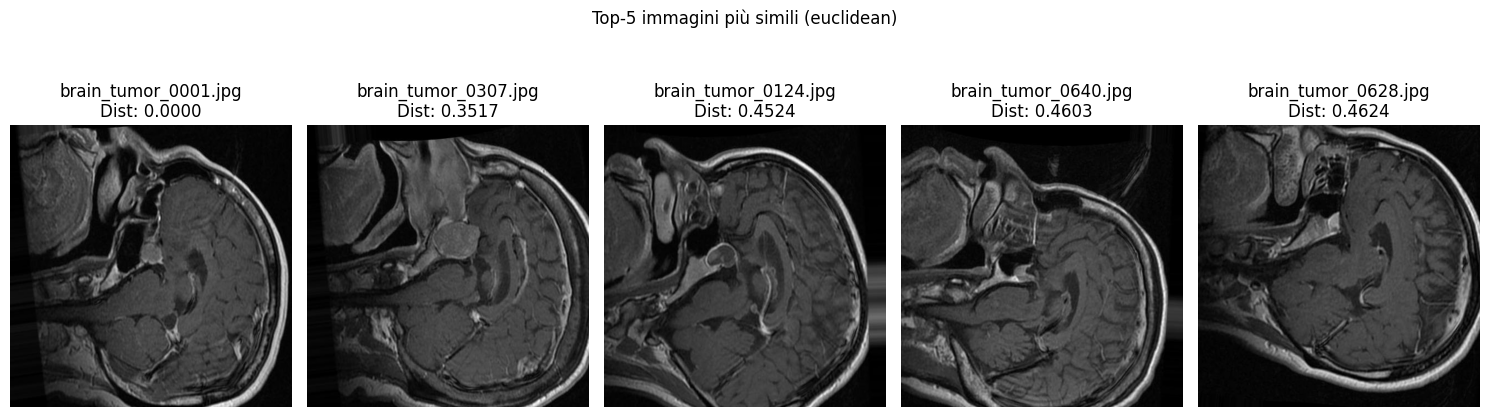

In [16]:
# === Parametri ===
query_image_path = "Part1/brain_tumor/brain_tumor_0001.jpg"  # Sostituisci con il percorso corretto
k = 5
features_npz = "resnet_features_part1.npz"
base_folder = "Part1"

# === Chiamata con distanza euclidea ===
# find_top_k_similar(query_image_path, k, features_npz, model, base_folder, metric="euclidean")

# === Chiamata con similarità coseno ===
find_top_k_similar(query_image_path, k, features_npz, model, base_folder, metric="euclidean")


Task 4:

In [17]:

def compute_metric(query_feat, target_feats, metric="euclidean"):
    """
    Calcola la distanza o similarità tra query_feat e un set di target_feats.
    """
    query_feat = query_feat.reshape(1, -1)
    if metric == "euclidean":
        return np.linalg.norm(target_feats - query_feat, axis=1)
    elif metric == "cosine":
        return cosine_similarity(query_feat, target_feats)[0]
    else:
        raise ValueError("Metric must be 'euclidean' or 'cosine'")

def predict_top_k_labels_distance_mean(query_img_path, k, model, metric="euclidean"):
    """
    Strategia 1: etichetta più vicina in media nel feature space.
    """
    data = np.load("resnet_features_all.npz")
    features = data['features']
    labels = data['labels']

    query_feat = extract_and_process_image(query_img_path, model)

    unique_labels = np.unique(labels)
    avg_scores = []

    for label in unique_labels:
        class_feats = features[labels == label]
        scores = compute_metric(query_feat, class_feats, metric)
        avg_scores.append(scores.mean())

    # Ordinamento (euclidea: valori più piccoli = migliori; cosine: valori più grandi = migliori)
    if metric == "euclidean":
        sorted_indices = np.argsort(avg_scores)
    else:  # cosine
        sorted_indices = np.argsort(avg_scores)[::-1]

    print(f"--- Top-{k} etichette - Distanza media ({metric}) ---")
    for i in range(min(k, len(unique_labels))):
        idx = sorted_indices[i]
        print(f"{unique_labels[idx]} \t Score medio: {avg_scores[idx]:.4f}")

def predict_top_k_labels_prototype(query_img_path, k, model, metric="euclidean"):
    """
    Strategia 2: distanza/similarità rispetto al prototipo (media) della classe.
    """
    data = np.load("resnet_features_all.npz")
    features = data['features']
    labels = data['labels']

    query_feat = extract_and_process_image(query_img_path, model)

    unique_labels = np.unique(labels)
    prototypes = []
    for label in unique_labels:
        class_feats = features[labels == label]
        prototypes.append(class_feats.mean(axis=0))
    prototypes = np.vstack(prototypes)

    scores = compute_metric(query_feat, prototypes, metric)

    if metric == "euclidean":
        sorted_indices = np.argsort(scores)
    else:
        sorted_indices = np.argsort(scores)[::-1]

    print(f"--- Top-{k} etichette - Prototipo classe ({metric}) ---")
    for i in range(min(k, len(unique_labels))):
        idx = sorted_indices[i]
        print(f"{unique_labels[idx]} \t Score: {scores[idx]:.4f}")

def task4_predict_labels(query_img_path, k, model, metric="euclidean"):
    assert k <= 2, "k deve essere <= 2"
    print(f"Predizione top-{k} per immagine '{query_img_path}' usando metrica '{metric}'")
    predict_top_k_labels_distance_mean(query_img_path, k, model, metric)
    print()
    predict_top_k_labels_prototype(query_img_path, k, model, metric)


Esecuzione

In [18]:
query_img = "Part2/brain_glioma/brain_glioma_1112.jpg"

task4_predict_labels(query_img, k=2, model=model, metric="euclidean")
print()
task4_predict_labels(query_img, k=2, model=model, metric="cosine")


Predizione top-2 per immagine 'Part2/brain_glioma/brain_glioma_1112.jpg' usando metrica 'euclidean'
--- Top-2 etichette - Distanza media (euclidean) ---
brain_glioma 	 Score medio: 0.6539
brain_menin 	 Score medio: 0.7890

--- Top-2 etichette - Prototipo classe (euclidean) ---
brain_glioma 	 Score: 0.3942
brain_menin 	 Score: 0.5319

Predizione top-2 per immagine 'Part2/brain_glioma/brain_glioma_1112.jpg' usando metrica 'cosine'
--- Top-2 etichette - Distanza media (cosine) ---
brain_glioma 	 Score medio: 0.9750
brain_menin 	 Score medio: 0.9644

--- Top-2 etichette - Prototipo classe (cosine) ---
brain_glioma 	 Score: 0.9911
brain_menin 	 Score: 0.9839


Task 5:

In [19]:
def plot_latent_space_2d(X_transformed, labels, technique, k):
    """Visualizza la proiezione 2D dello spazio latente."""
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    """Visualizza i cluster KMeans in 2D usando SVD per proiezione."""
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()


In [20]:

def task5_latent_semantics_resnet(feature_model_path, technique, k):
    """
    Estrae i top-k concetti latenti da uno spazio di feature ResNet usando SVD, LDA o KMeans.
    Salva i risultati su file e visualizza lo spazio latente.

    Parametri:
    ------------
    - feature_model_path: percorso file .npz (es. "resnet_layer3.npz")
    - technique: "svd", "lda", "kmeans"
    - k: numero componenti/cluster da estrarre
    """

    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k, random_state=42)
        X_transformed = model.fit_transform(feat_matrix_part1)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(lbls_part1)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feat_matrix_part1, lbls_part1)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feat_matrix_part1)
        components = model.cluster_centers_
        X_transformed = model.transform(feat_matrix_part1)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # === Visualizzazione ===
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, lbls_part1, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feat_matrix_part1, lbls_part1, k)

    # === Output file ===
    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = f"latent_semantics_{method}_{base_name}_k{k}.txt"

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feat_matrix_part1 @ components[i].T
            else:
                weights = -X_transformed[:, i]  # distanza inversa

            sorted_idx = np.argsort(-np.abs(weights))
            for idx in sorted_idx:
                f.write(f"{flname_part1[idx]} | Peso: {weights[idx]:.4f} | Classe: {lbls_part1[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")


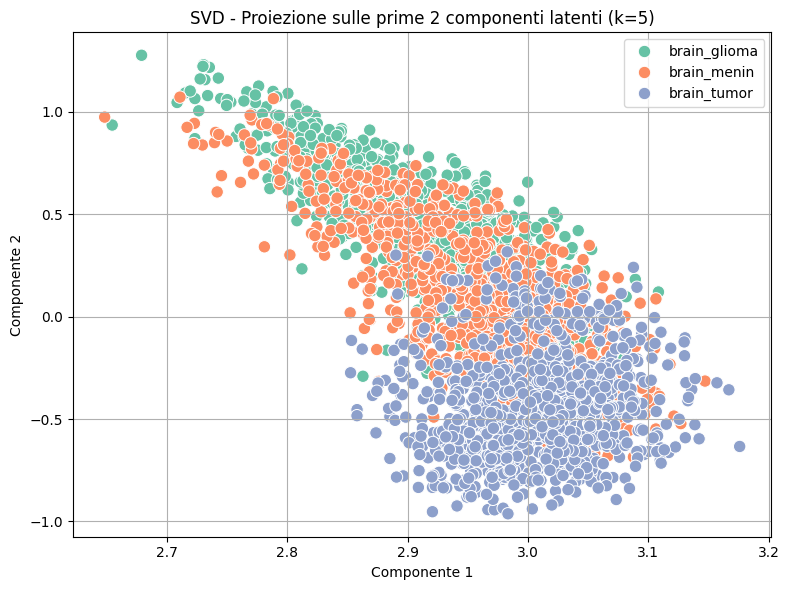

[SALVATO] Latent semantics salvati in: latent_semantics_svd_resnet_features_all_k5.txt


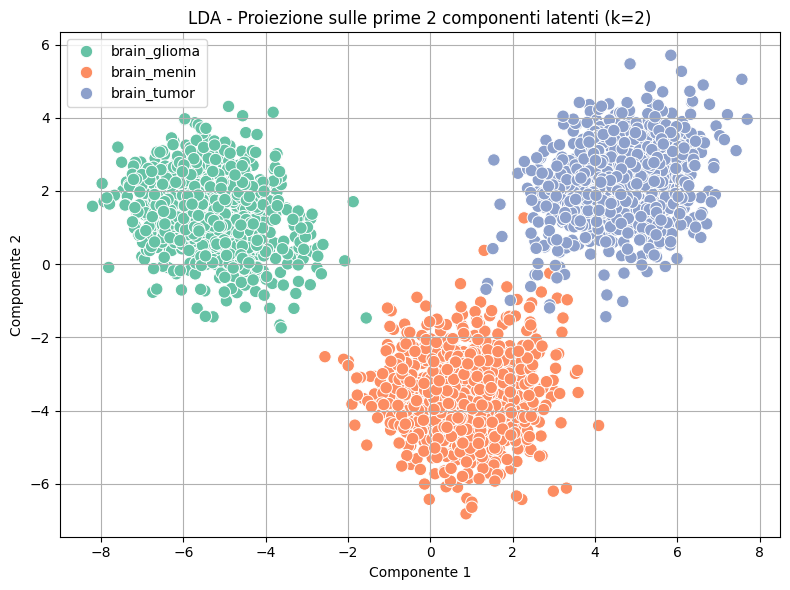

[SALVATO] Latent semantics salvati in: latent_semantics_lda_resnet_features_all_k2.txt


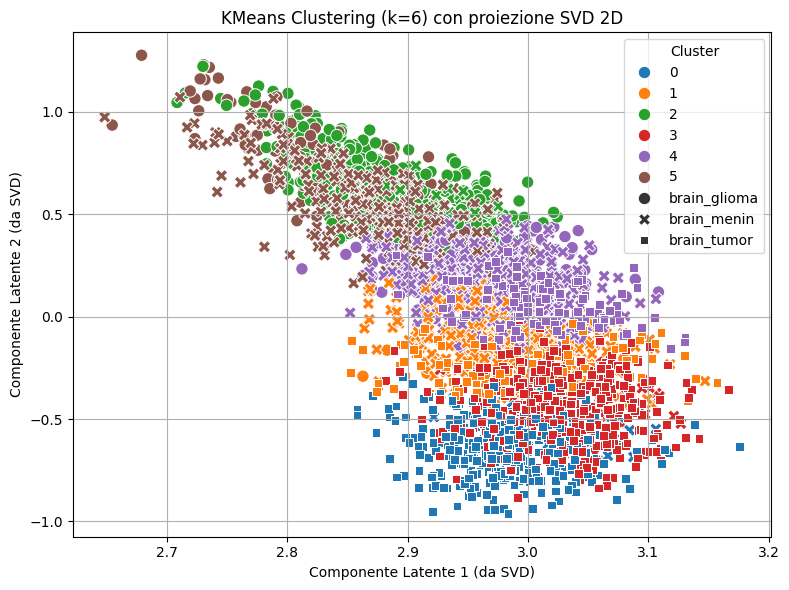

[SALVATO] Latent semantics salvati in: latent_semantics_kmeans_resnet_features_all_k6.txt


In [21]:
# Supponendo tu abbia salvato il file .npz come "resnet_layer3.npz"
task5_latent_semantics_resnet("resnet_features_all.npz", technique="svd", k=5)
task5_latent_semantics_resnet("resnet_features_all.npz", technique="lda", k=2)
task5_latent_semantics_resnet("resnet_features_all.npz", technique="kmeans", k=6)


Task 6:

In [22]:

def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    #print(f"[INFO] Spiegazione varianza per ogni componente PCA:\n{explained}")
    #print(f"[INFO] Varianza cumulativa:\n{cumulative}")
    #print(f"[INFO] Soglia impostata: {threshold}")
    #print(f"[INFO] Dimensione intrinseca stimata: {intrinsic_dim}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA/SVD)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative

def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values


In [23]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}

    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" Label '{label}' : k = {k}")

    return label_dim_map


\Stima automatica di k in base alla varianza spiegata:

[INFO] Feature matrix shape: (3006, 1024)


<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
/var/folders/6q/jmt5rhf501363h2f7_4cnrjh0000gn/T/ipykernel_30413/1321706206.py:2: SyntaxWarning: invalid escape sequence '\S'
  print("\Stima automatica di k in base alla varianza spiegata:\n")


[INFO] k ottimale suggerito (soglia 90%): 26
Soglia 90% : k = 26
[INFO] k ottimale suggerito (soglia 95%): 54
Soglia 95% : k = 54
[INFO] k ottimale suggerito (soglia 99%): 269
Soglia 99% : k = 269


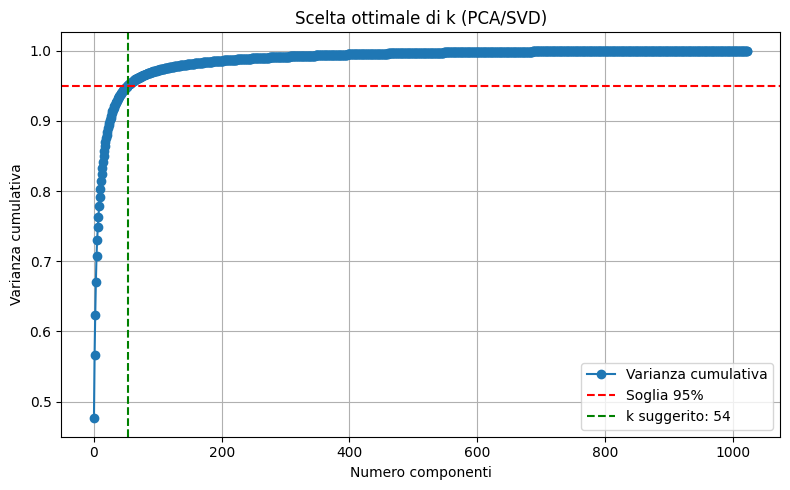

[INFO] k ottimale suggerito (soglia 95%): 54

 Task 6b – Dimensionalità per etichetta:

[INFO] Etichette uniche trovate: 3
[INFO] k ottimale suggerito (soglia 95%): 64
 Label 'brain_glioma' : k = 64
[INFO] k ottimale suggerito (soglia 95%): 62
 Label 'brain_menin' : k = 62
[INFO] k ottimale suggerito (soglia 95%): 75
 Label 'brain_tumor' : k = 75


In [24]:
# Calcola k per varie soglie
print("\Stima automatica di k in base alla varianza spiegata:\n")
k_suggeriti = suggest_k(feat_matrix_part1)
# Plot dettagliato per la soglia 95%
estimate_intrinsic_dimensionality(feat_matrix_part1, threshold=0.95, plot=True)


print("\n Task 6b – Dimensionalità per etichetta:\n")
label_dimensionalities = estimate_dimensionality_per_label(feat_matrix_part1, lbls_part1, threshold=0.95)

Task 7:

In [25]:
def compute_latent_semantics_per_class(X, y, k=10):
    class_models = {}
    class_means = {}

    labels = np.unique(y)
    for label in labels:
        X_class = X[y == label]  # Prende solo le istanze della classe corrente
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)  # Normalizza i dati della classe

        svd = TruncatedSVD(n_components=k)
        latent = svd.fit_transform(X_scaled)  # Riduzione dimensionale con SVD

        # Salva modello SVD e scaler per la classe
        class_models[label] = {
            'svd': svd,
            'scaler': scaler,
            'latent_vectors': latent
        }
        # Calcola la media dei vettori latenti della classe
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_label(X_test, class_models, class_means):
    y_pred = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))  # Normalizza x
            x_latent = model['svd'].transform(x_scaled)  # Trasforma in spazio latente
            dist = np.linalg.norm(x_latent - class_means[label])  # Distanza dal centroide
            if dist < min_dist:
                min_dist = dist
                best_label = label
        y_pred.append(best_label)
    return y_pred


def evaluate(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    labels = np.unique(y_true)
    print("Per-class metrics:")
    for i, label in enumerate(labels):
        print(
            f"Class {label}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
    print(f"\nOverall Accuracy: {accuracy:.2f}\n")

    print(classification_report(y_true, y_pred))


def evaluate_predictions(true_labels, predicted_labels):
    print("[VALUTAZIONE] Report di classificazione:")
    print(classification_report(true_labels, predicted_labels))

In [26]:
# Addestramento sui dati di Part1
class_models, class_means = compute_latent_semantics_per_class(
    feat_matrix_part1, lbls_part1, k=10)

# Predizione su Part2
predicted_labels = predict_label(feat_matrix_part2, class_models, class_means)

# Valutazione
evaluate(lbls_part2, predicted_labels)

Per-class metrics:
Class brain_glioma: P=0.82, R=0.68, F1=0.74
Class brain_menin: P=0.56, R=0.57, F1=0.56
Class brain_tumor: P=0.73, R=0.83, F1=0.78

Overall Accuracy: 0.69

              precision    recall  f1-score   support

brain_glioma       0.82      0.68      0.74      1002
 brain_menin       0.56      0.57      0.56      1002
 brain_tumor       0.73      0.83      0.78      1002

    accuracy                           0.69      3006
   macro avg       0.70      0.69      0.69      3006
weighted avg       0.70      0.69      0.69      3006



task 8

In [36]:

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from PIL import Image

def apply_dbscan_with_pca(features, eps=2.0, min_samples=3, n_components=50):
    """
    Riduce 'features' a 'n_components' dimensioni con PCA, quindi applica DBSCAN
    e restituisce l'array di cluster-labels (interi) di lunghezza = numero di righe in 'features'.
    """
    print(f"[INFO] PCA -> Riduzione a {n_components} componenti")
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)

    scaler = StandardScaler()
    reduced_scaled = scaler.fit_transform(reduced_features)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(reduced_scaled)
    return labels


def top_c_clusters(cluster_labels, c):
    """
    cluster_labels: array di interi di lunghezza N.
    c: numero di cluster "più popolosi" che vogliamo restituire.
    Restituisce la lista dei c valori di cluster (escludendo -1) 
    ordinati in base alla dimensione (numero di occorrenze) decrescente.
    Se DBSCAN ha trovato meno di c cluster, restituisce tutti quelli disponibili.
    """
    # Conteggio delle occorrenze per ogni etichetta di cluster
    label_counts = Counter(cluster_labels)
    # Rimuovo il rumore (-1) se presente
    label_counts.pop(-1, None)
    
    if not label_counts:
        print("[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).")
        return []
    
    # Estraiamo i c cluster più frequenti
    most_common = label_counts.most_common(c)  # es. [(label1, count1), (label2, count2), ...]
    top = [int(lbl) for lbl, _ in most_common]
    
    # Se DBSCAN ha trovato meno di c cluster, most_common contiene già tutti
    if len(top) < c:
        print(f"[WARN] DBSCAN ha trovato solo {len(top)} cluster (meno di {c}).")
    return top


def plot_mds_clusters(features, cluster_labels, top_clusters, metric='euclidean'):
    """
    features: array (N, d) delle tue feature originali (senza aver fatto PCA).
    cluster_labels: array (N,) con i risultati DBSCAN.
    top_clusters: lista di interi pari ai cluster "significativi" (col più grandi).
    metric: la distanza da usare per MDS (default 'euclidean').
    Mostra un grafico 2D (scatter) con i punti appartenenti ai top_clusters colorati diversamente,
    tutti gli altri (cluster minori o -1) in grigio chiaro.
    """
    # 1) Normalizzo / scalizzo le features originali
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 2) Calcolo la matrice di distanze (facoltativo) e poi MDS → Y (N×2)
    #    Qui usiamo MDS “direttamente” su features_scaled, che di default assume euclidea.
    mds = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
    Y = mds.fit_transform(features_scaled)

    # 3) Plotto i punti
    import matplotlib
    cmap= matplotlib.colormaps['tab10']

    plt.figure(figsize=(6, 6))
    for i in range(len(Y)):
        lbl = cluster_labels[i]
        if lbl in top_clusters:
            color_idx = top_clusters.index(lbl)
            plt.scatter(Y[i,0], Y[i,1], color=cmap(color_idx), s=30, edgecolor='k', linewidth=0.2)
        else:
            # punti rumore o cluster “non top”
            plt.scatter(Y[i,0], Y[i,1], color='lightgray', s=8)

    plt.title(f"MDS 2D – Top {len(top_clusters)} cluster")
    plt.xlabel("MDS 1")
    plt.ylabel("MDS 2")
    plt.tight_layout()
    plt.show()


def show_cluster_thumbnails(images, cluster_labels, top_clusters, thumb_size=(64, 64)):
    """
    images: lista (o array) di percorsi file (lunghezza N), 
            ossia a images[i] corrisponde features[i].
    cluster_labels: array (N,) di cluster per ogni immagine.
    top_clusters: lista dei c cluster (int) che vogliamo visualizzare.
    thumb_size: dimensione (w,h) di ogni miniatura.
    Per ogni cluster ∈ top_clusters stampa a video (o fa plt.show) 
    una griglia di miniature (fino a ~16‐25 alla volta).
    """
    for cluster_id in top_clusters:
        # Indici di tutte le immagini che appartengono a questo cluster
        idxs = [i for i, cl in enumerate(cluster_labels) if cl == cluster_id]
        print(f"[INFO] Cluster {cluster_id}: {len(idxs)} immagini trovate")

        # Se vogliamo limitare a N miniatura per cluster (tipo 16):
        max_display = min(len(idxs), 16)
        n = int(np.ceil(np.sqrt(max_display)))  # facciamo una griglia n×n
        plt.figure(figsize=(n, n))

        for j, i_img in enumerate(idxs[:max_display]):
            img = Image.open(images[i_img]).convert('RGB')
            img_thumb = img.resize(thumb_size, Image.LANCZOS)


            ax = plt.subplot(n, n, j+1)
            plt.imshow(img_thumb)
            plt.axis('off')

        plt.suptitle(f"Cluster {cluster_id} – {len(idxs)} immagini (mostrate: {max_display})")
        plt.tight_layout()
        plt.show()



[INFO] Elaboro label: brain_glioma
[INFO] PCA -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1]
[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).
[INFO] Top 3 cluster (per dimensione): []
[INFO] Disegno MDS 2D per i cluster di 'brain_glioma' …


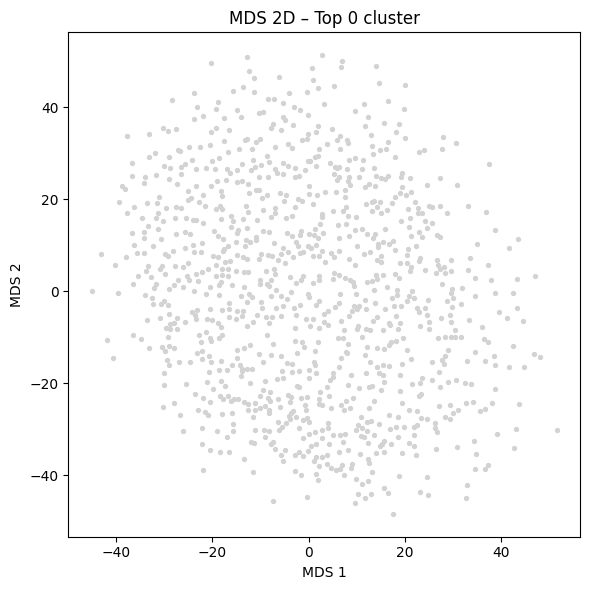

[INFO] Genero miniature per ciascun cluster di 'brain_glioma' …

[INFO] Elaboro label: brain_menin
[INFO] PCA -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1]
[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).
[INFO] Top 3 cluster (per dimensione): []
[INFO] Disegno MDS 2D per i cluster di 'brain_menin' …


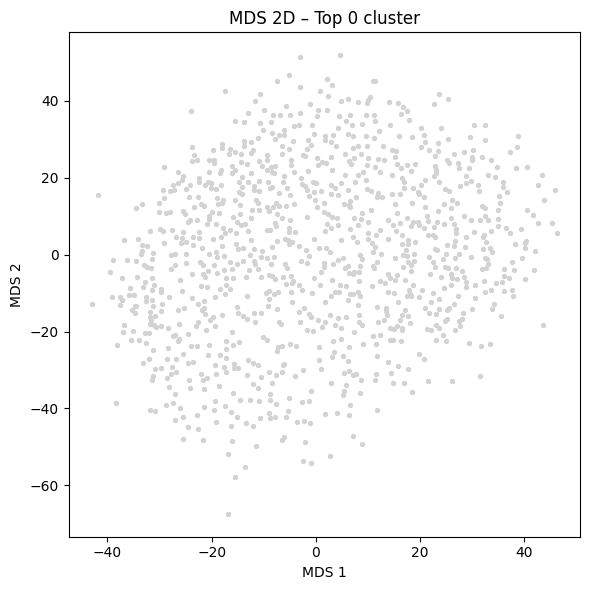

[INFO] Genero miniature per ciascun cluster di 'brain_menin' …

[INFO] Elaboro label: brain_tumor
[INFO] PCA -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1]
[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).
[INFO] Top 3 cluster (per dimensione): []
[INFO] Disegno MDS 2D per i cluster di 'brain_tumor' …


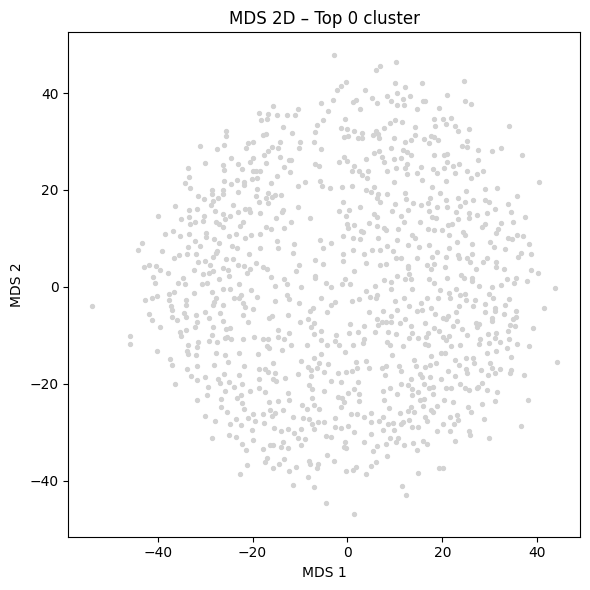

[INFO] Genero miniature per ciascun cluster di 'brain_tumor' …

[FINITO] Task 8 completato per tutte le label di Parte1.


In [37]:
# ================================
# BLOCCHETTO PER TASK 8 (RIUSO FUNZIONI)
# ================================

# 3) PARAMETRI (modificabili a piacere)
eps = 2.0            # valore DBSCAN di esempio
min_samples = 3      # valore DBSCAN di esempio
n_components = 50    # quante dimensioni tenere con PCA PRIMA di DBSCAN
c = 3                # quanti cluster “significativi” voglio prendere per ciascuna label

# 4) Creare una cartella di output (facoltativo)
output_base = "./results_task8"
os.makedirs(output_base, exist_ok=True)

# 3) Costruisco l’elenco dei full path per tutte le immagini
base_folder = "Part1"  # o path assoluto "/Users/.../Parte1"
images_full = [ os.path.join(base_folder, lbl, fname)
                for fname, lbl in zip(flname_part1, lbls_part1) ]

# 5) SCORRO OGNI LABEL DI Parte1 E APPLICO DBSCAN+PCA
unique_labels = np.unique(lbls_part1)  # es. ["Glioma","Meningioma","Pituitary"]

for lbl in unique_labels:
    print(f"\n==============================")
    print(f"[INFO] Elaboro label: {lbl}")
    print(f"==============================")

    # 5.1) Estraggo le righe di feat_matrix_part1 / flname_part1 corrispondenti
    mask_lbl = (lbls_part1 == lbl)
    features_label = feat_matrix_part1[mask_lbl]   # shape = (n_i, d)
    images_label   = np.array(images_full)[mask_lbl]

    # 5.2) Chiamo la tua funzione che fa PCA + DBSCAN
    cluster_labels = apply_dbscan_with_pca(
        features_label,
        eps=eps,
        min_samples=min_samples,
        n_components=n_components
    )
    print(f"[INFO] Cluster-labels trovati: {np.unique(cluster_labels)}")

    # 5.3) Trovo i c cluster più grandi
    top_clusters = top_c_clusters(cluster_labels, c)
    print(f"[INFO] Top {c} cluster (per dimensione): {top_clusters}")

    # 5.4) Creo sotto-cartella di output per questa label
    out_dir_lbl = os.path.join(output_base, f"label_{lbl}")
    os.makedirs(out_dir_lbl, exist_ok=True)

    # 5.5) MDS‐2D + scatter plot del clustering
    print(f"[INFO] Disegno MDS 2D per i cluster di '{lbl}' …")
    # (ATTENZIONE: plot_mds_clusters in genere “fa plt.show()” a video.
    #  Se vuoi salvare l’immagine invece di far vedere a notebook, 
    #  devi modificare leggermente quella funzione per usare plt.savefig())
    plot_mds_clusters(
        features_label,
        cluster_labels,
        top_clusters,
        metric='euclidean'
    )
    # Se invece vuoi **salvare** l’immagine in PNG anziché fare “show()”:
    #    plt.savefig(os.path.join(out_dir_lbl, f"{lbl}_MDS_clusters.png"))
    #    plt.close()

    # 5.6) Creo le miniature di ogni cluster “significativo”
    print(f"[INFO] Genero miniature per ciascun cluster di '{lbl}' …")
    show_cluster_thumbnails(
        images_label,      # array di stringhe di percorsi
        cluster_labels,    # array di int di lunghezza n_i
        top_clusters,      # la lista dei c indici di cluster
        thumb_size=(64, 64)
    )
    # Anche qui, di default quella funzione fa plt.show() per ogni cluster.
    # Se vuoi salvare le figure in file, modifica show_cluster_thumbnails in
    # modo che setti un outpath e faccia plt.savefig().

print("\n[FINITO] Task 8 completato per tutte le label di Parte1.")


task 9:

In [28]:


# Imposta il valore di m per l'm-NN
m = 5  # Modifica questo valore in base alle tue necessità

# Addestramento m-NN
knn_model = KNeighborsClassifier(n_neighbors=m)
knn_model.fit(feat_matrix_part1, lbls_part1)

# Addestramento Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(feat_matrix_part1, lbls_part1)

# Predizioni su Part2
pred_knn = knn_model.predict(feat_matrix_part2)
pred_dt = dt_model.predict(feat_matrix_part2)

# Valutazione m-NN
print("Risultati m-NN:")
print(classification_report(lbls_part2, pred_knn))
print("Accuratezza complessiva m-NN:", accuracy_score(lbls_part2, pred_knn))

# Valutazione Decision Tree
print("Risultati Decision Tree:")
print(classification_report(lbls_part2, pred_dt))
print("Accuratezza complessiva Decision Tree:", accuracy_score(lbls_part2, pred_dt))


Risultati m-NN:
              precision    recall  f1-score   support

brain_glioma       0.97      0.98      0.97      1002
 brain_menin       0.94      0.92      0.93      1002
 brain_tumor       0.95      0.96      0.96      1002

    accuracy                           0.95      3006
   macro avg       0.95      0.95      0.95      3006
weighted avg       0.95      0.95      0.95      3006

Accuratezza complessiva m-NN: 0.9520958083832335
Risultati Decision Tree:
              precision    recall  f1-score   support

brain_glioma       0.92      0.93      0.92      1002
 brain_menin       0.85      0.81      0.83      1002
 brain_tumor       0.88      0.91      0.89      1002

    accuracy                           0.88      3006
   macro avg       0.88      0.88      0.88      3006
weighted avg       0.88      0.88      0.88      3006

Accuratezza complessiva Decision Tree: 0.8832335329341318


Task 10

In [29]:
# Classe LSH con quantizzazione

class LSH_EuclideanQuantized:
    """
    LSH per distanza Euclidea (p-stable) con bucket width r.
    Ogni hash h_j(v) = floor((a_j · v + b_j) / r).

    Parametri:
      - num_layers   = L = numero di tavole hash
      - num_hashes   = h = numero di functions concatenati in ciascuna tavola
      - dim          = D = dimensione dei vettori di input
      - r            = bucket width (parte intera di quantizzazione)
    """

    def __init__(self, num_layers: int, num_hashes: int, dim: int, r: float):
        self.L = num_layers
        self.h = num_hashes
        self.d = dim
        self.r = r

        # Prepara L tavole hash: ciascuna è un dict (chiave tuple di h interi -> lista di indici)
        self.hash_tables = [defaultdict(list) for _ in range(self.L)]

        # Per ogni layer l=0..L-1, e per ogni j=0..h-1, genero:
        #   - a_lj  vettore gaussiano di dimensione D
        #   - b_lj  offset (uniforme in [0, r) )
        self.a_vectors = [
            [np.random.randn(self.d) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.b_offsets = [
            [np.random.uniform(0, self.r) for _ in range(self.h)]
            for _ in range(self.L)
        ]

        # Memorizzerò i vettori originali di Part1 in questo array, shape=(N, D)
        self.data_vectors = None

    def _compute_hash_tuple(self, vec: np.ndarray, layer_idx: int) -> tuple:
        """
        Calcola l'hash (h interi) per il layer layer_idx su un vettore vec:
          h_j = floor((a_vectors[layer_idx][j] · vec + b_offsets[layer_idx][j]) / r)
        Ritorna una tupla di h interi.
        """
        keys = []
        a_vs = self.a_vectors[layer_idx]
        b_os = self.b_offsets[layer_idx]
        for j in range(self.h):
            a_j = a_vs[j]         # vettore dimensione D
            b_j = b_os[j]         # float in [0, r)
            proj = float(np.dot(a_j, vec) + b_j)
            h_val = int(np.floor(proj / self.r))
            keys.append(h_val)
        return tuple(keys)

    def index(self, vectors: np.ndarray):
        """
        Costruisci l'indice LSH su un insieme di vettori di Part1:
          vectors: numpy array shape = (N, D)
        Al termine di questa chiamata:
          - self.data_vectors = vectors
          - self.hash_tables[l][hash_tuple] conterrà la lista di indici i per cui
            hash_tuple = _compute_hash_tuple(vectors[i], l).
        """
        self.data_vectors = vectors
        N, D = vectors.shape
        assert D == self.d, f"Errore: dimensione vettore ({D}) ≠ atteso ({self.d})."

        # Inserisco ogni vettore in ciascuna tavola hash
        for idx in range(N):
            v = vectors[idx]
            for l in range(self.L):
                key = self._compute_hash_tuple(v, l)
                self.hash_tables[l][key].append(idx)

    def query(self, q_vec: np.ndarray, top_t: int = 5):
        """
        Esegui una query LSH per cercare i top_t vettori più vicini a q_vec.
        Restituisce:
          - top_results: lista di tuple (indice, distanza) ord. per dist. crescente
          - unique_count: numero di indici distinti considerati (cardinalità dei candidati)
          - total_checked: somma della lunghezza di tutti i bucket esaminati
        """
        assert q_vec.shape[0] == self.d, "Errore: dimensione query ≠ D."
        candidati = set()
        total_checked = 0

        # Per ciascun layer, ottengo la chiave polidimensionale e i suoi bucket
        for l in range(self.L):
            h_tuple = self._compute_hash_tuple(q_vec, l)
            bucket = self.hash_tables[l].get(h_tuple, [])
            total_checked += len(bucket)
            candidati.update(bucket)

        # Ora calcolo la distanza euclidea esatta tra q_vec e ciascun candidato
        risultati = []
        for idx in candidati:
            v_i = self.data_vectors[idx]
            dist = np.linalg.norm(v_i - q_vec)
            risultati.append((idx, dist))

        # Ordino e prendo i primi top_t
        risultati.sort(key=lambda x: x[1])
        top_results = risultati[:top_t]
        return top_results, len(candidati), total_checked


In [30]:
# costruzione LSH_EuclideanQuantized su Part1

# 1) (Opzionale ma consigliato) centra e normalizza i vettori di Part1
#    Questo passaggio riduce l'effetto di scale diverse e spesso migliora la qualità LSH
mean_vec = np.mean(feat_matrix_part1, axis=0)
feat_centered = feat_matrix_part1 - mean_vec
feat_normed = normalize(feat_centered, norm='l2', axis=1)

# 2) Parametri LSH
D = feat_normed.shape[1]      # di solito 900
L = 10                         # numero di tavole hash (scegli in base a esperimenti)
h = 7                      # numero di funzioni concatenati in ciascuna tavola
r = 1                       # parametro di larghezza (esempio: 0.5); puoi sperimentare

# 3) Creo l'oggetto e indicizzo
lsh_quant = LSH_EuclideanQuantized(num_layers=L, num_hashes=h, dim=D, r=r)
lsh_quant.index(feat_normed)

print(f"[INFO] LSH quantizzato costruito: D={D}, L={L}, h={h}, r={r}")


[INFO] LSH quantizzato costruito: D=1024, L=10, h=7, r=1


In [31]:
#funzione per cercare top_k con LSH quantizzato

def find_k_similar_lsh_quant(base_folder: str, img_path: str, k: int):
    """
    Cerca le k immagini di Part1 più simili a img_path (di Part2) usando LSH_EuclideanQuantized.
    Stampa:
      - i primi k risultati (file name, label, distanza)
      - il numero di immagini uniche considerate
      - il numero totale di controlli (somma delle lunghezze dei bucket)
    E poi visualizza (query + k risultati) con matplotlib.
    """
    # 1) Estrazione feature raw (900-dim) con la funzione esistente
    raw_q = np.array(extract_and_process_image(img_path,model), dtype=np.float32)

    # 2) Center + normalize (stesso mean_vec e L2 norm usati su Part1)
    q_centered = raw_q - mean_vec
    q_normed = q_centered / np.linalg.norm(q_centered)

    # 3) Chiamata a LSH
    top_results, unique_count, total_checked = lsh_quant.query(q_normed, top_t=k)

    # 4) Stampa output testuale
    print(f"\n[LSH-Quant] Top {k} simili a: {img_path}")
    for rank, (idx, dist) in enumerate(top_results, start=1):
        label = lbls_part1[idx]
        fname = flname_part1[idx]
        print(f"  {rank}. {fname} | Classe: {label} | Distanza Euclidea: {dist:.2f}")
    print(f"[LSH-Quant] Immagini uniche considerate: {unique_count}")
    print(f"[LSH-Quant] Immagini totali controllate: {total_checked}")

    # 5) Visualizzazione (query + primi k risultati)
    fig, axs = plt.subplots(1, k+1, figsize=(4*(k+1), 4))
    img_q = cv2.imread(img_path)
    img_q = cv2.cvtColor(img_q, cv2.COLOR_BGR2RGB)
    axs[0].imshow(img_q)
    axs[0].set_title("Query (LSH-Quant)")
    axs[0].axis('off')

    for i, (idx, dist) in enumerate(top_results, start=1):
        lab = lbls_part1[idx]
        fname = flname_part1[idx]
        full_path = os.path.join(base_folder, lab, fname)
        img_match = cv2.imread(full_path)
        img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_match)
        axs[i].set_title(f"Rank {i}\nd={dist:.2f}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()



[LSH-Quant] Top 5 simili a: Part2/brain_glioma/brain_glioma_1409.jpg
  1. brain_glioma_0757.jpg | Classe: brain_glioma | Distanza Euclidea: 0.77
  2. brain_glioma_0234.jpg | Classe: brain_glioma | Distanza Euclidea: 0.82
  3. brain_glioma_0771.jpg | Classe: brain_glioma | Distanza Euclidea: 0.83
  4. brain_glioma_0200.jpg | Classe: brain_glioma | Distanza Euclidea: 0.84
  5. brain_glioma_0502.jpg | Classe: brain_glioma | Distanza Euclidea: 0.88
[LSH-Quant] Immagini uniche considerate: 16
[LSH-Quant] Immagini totali controllate: 16


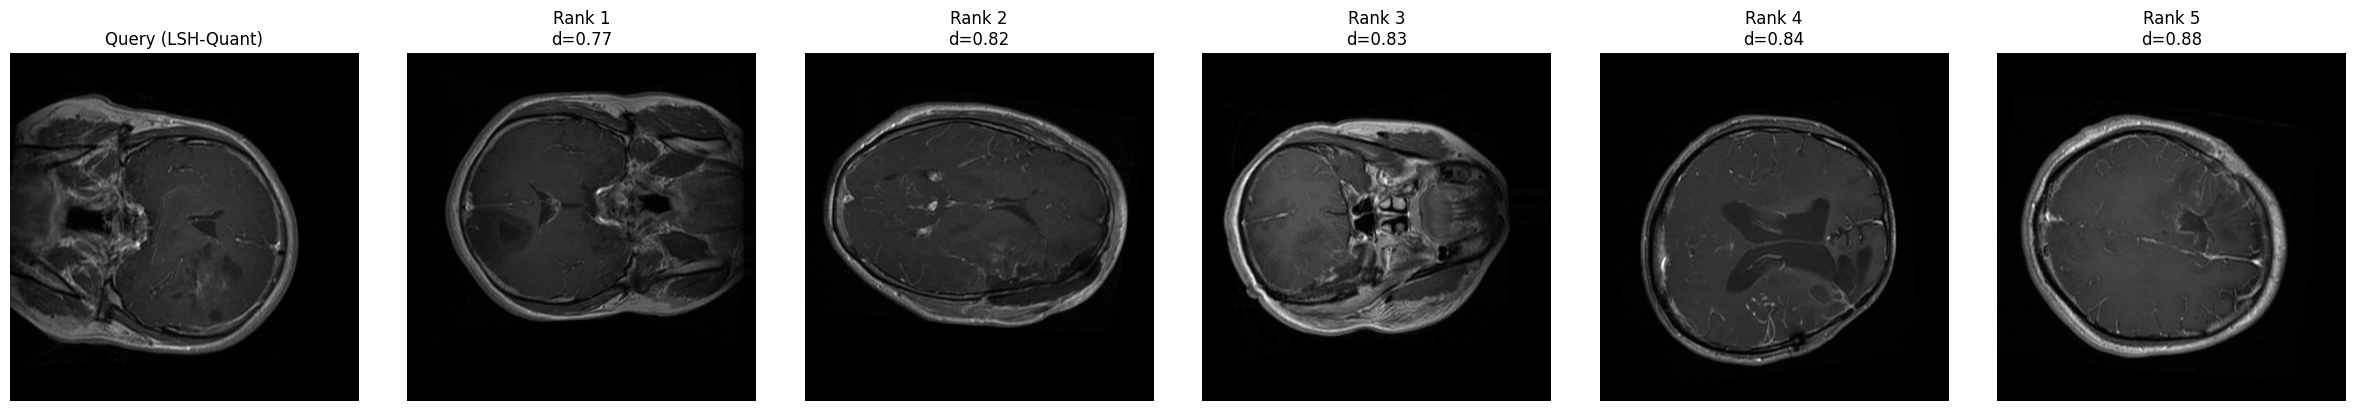

In [32]:
# Esempio di utilizzo su un'immagine di Part2 ---
query_path = "Part2/brain_glioma/brain_glioma_1409.jpg"

k = 5                         # numero di immagini simili da visualizzare

# Eseguo la ricerca LSH
find_k_similar_lsh_quant("Part1", query_path, k)
